Boosting Practice Teach for Galvinize
====================

Outline:

  - Opening example.
  - Outline.
  - You Could Have Invented Gradient Boosting.
  - Practical Gradient Boosting.
  - AdaBoost.

Opening Example
--------------

Boosting is a stunningly powerful, general purpose, off-the-shelf machine learning algorithm.

Allstate ran three Kaggle competitions, the winners of all three used Gradient Boosting as thier core learning algorithm.

In [193]:
%matplotlib inline

import numpy as np
import numpy.random as rand
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import sklearn.datasets as datasets
import sklearn.cross_validation as cv
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (8.0, 6.0)

from IPython.display import HTML

In [60]:
# Simple helper functions
to_column = lambda x: x.reshape((x.shape[0], 1))

## Boosting for regression.

In [68]:
N = 500
N_ESTIMATORS = 500

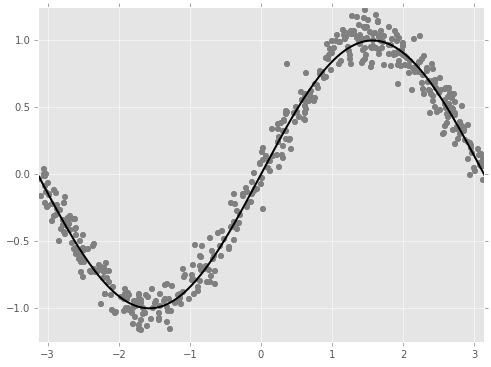

In [91]:
# Generate some data from a simple noiseless function
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)

xs = rand.uniform(-np.pi, np.pi, N)
ys = f(xs) + rand.normal(0, 0.1, N)

def plot_truth():
    plt.plot(x, y, color = 'black')
    plt.xlim([-np.pi, np.pi]); plt.ylim([-1.25, 1.25])
    
def plot_data():
    plt.plot(xs, ys, 'o', color='grey', markeredgewidth=0)
    
plot_data()
plot_truth()

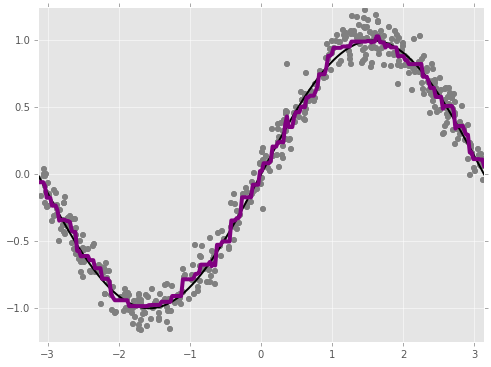

In [99]:
# Fit a gradient boosted regressor to this function and plot both the functiona and f

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=N_ESTIMATORS)
model.fit(to_column(xs), ys)

y_hat = model.predict(to_column(x))

plot_data()
plot_truth()
plt.plot(x, y_hat, color='purple', linewidth=4)

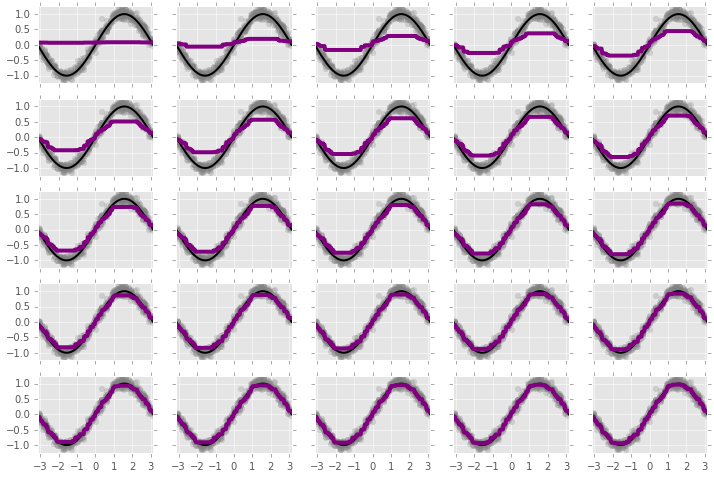

In [100]:
# Plot the partial sums of the weak learners to see what is going on.
# The point: the model learns gradually!

models = list(model.staged_predict(x.reshape(250, 1)))
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12.0, 8.0))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xs, ys, 'o', color='grey', markeredgewidth=0, alpha=0.25)
    ax.plot(x, y, color = 'black')
    ax.plot(x, models[15*i], color="purple", linewidth=4)
    plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])

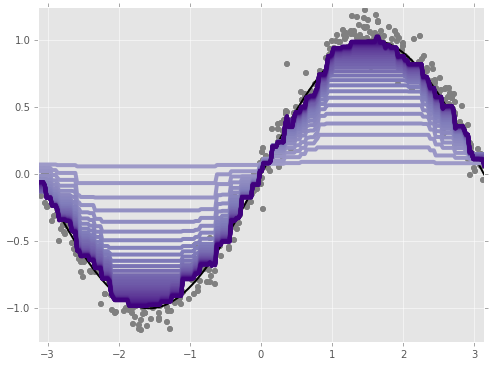

In [101]:
plot_data()
plot_truth()
for i, pred in enumerate(model.staged_predict(to_column(x))):
    if i % 15 == 1:
        plt.plot(x, pred, color=plt.cm.Purples(float(i) / 1000 + 0.5), linewidth=4)    

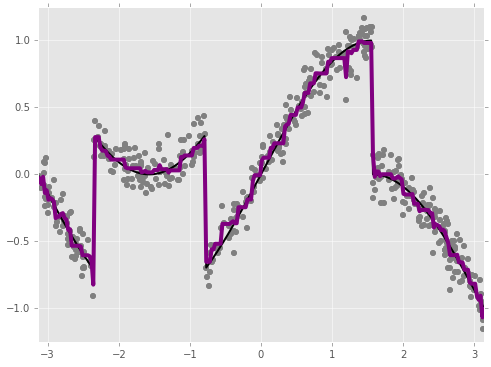

In [102]:
# Boosting can even handle complex, discontinuous loss functions

f_discontinuous = lambda x: f(x) + (x >= -0.75*np.pi)*(x <= -0.25*np.pi) - (x >= 0.5*np.pi)
y_discontinuous = f_discontinuous(x)
ys_discontinuous = f_discontinuous(xs) + rand.normal(0, 0.1, N)

def plot_discontinuous_truth():
    plt.plot(x, y_discontinuous, color = 'black')
    plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])
    
def plot_discontinuous_data():
    plt.plot(xs, ys_discontinuous, 'o', color='grey', markeredgewidth=0)

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000)
model.fit(to_column(xs), ys_discontinuous)

y_hat = model.predict(to_column(x))

plot_discontinuous_data()
plot_discontinuous_truth()
plt.plot(x, y_hat, color='purple', linewidth=4)

## Boosting for Classification

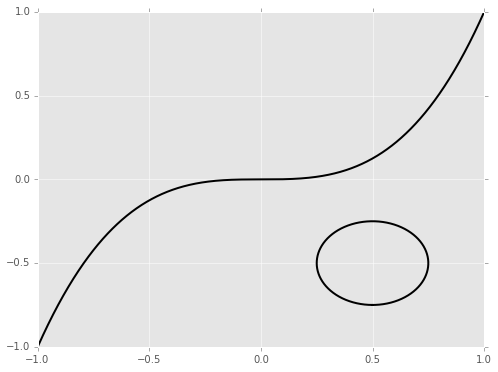

In [221]:
cubic_boundary = lambda t: (t, t**3)
circular_boundary = lambda t: (0.25*np.sin(t) + 0.5, 0.25*np.cos(t) - 0.5)

t_cubic = np.linspace(-1, 1, N)
x_cubic, y_cubic = cubic_boundary(t_cubic)
t_circle = np.linspace(-np.pi, np.pi, N)
x_circle, y_circle = circular_boundary(t_circle)

def plot_classification_boundary():
    plt.plot(x_cubic, y_cubic, color="black")
    plt.plot(x_circle, y_circle, color="black")
    plt.xlim([-1, 1]); plt.ylim([-1, 1])
    
plot_classification_boundary()    

In [222]:
N = 1500
N_ESTIMATORS = 1000

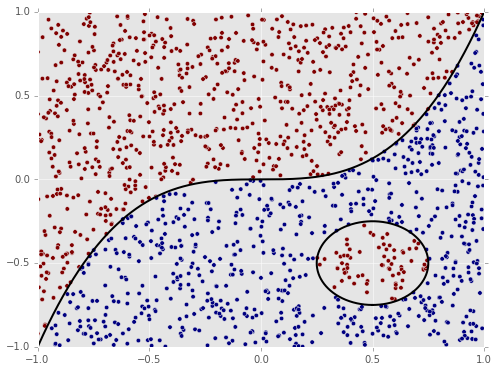

In [223]:
is_above_cubic = lambda x, y: x**3 < y
is_inside_circle = lambda x, y: (x - 0.5)**2 + (y + 0.5)**2 < 0.25**2
is_positive_class = lambda x, y: np.logical_or(is_above_cubic(x, y), is_inside_circle(x, y))

xs = rand.uniform(-1, 1, N)
ys = rand.uniform(-1, 1, N)
label = is_positive_class(xs, ys)

def plot_data():
    plt.scatter(xs, ys, c=label)

plot_data()
plot_classification_boundary()    

In [224]:
X = np.vstack([xs, ys]).T

model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=N_ESTIMATORS, min_samples_leaf=10)
model.fit(X, label)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

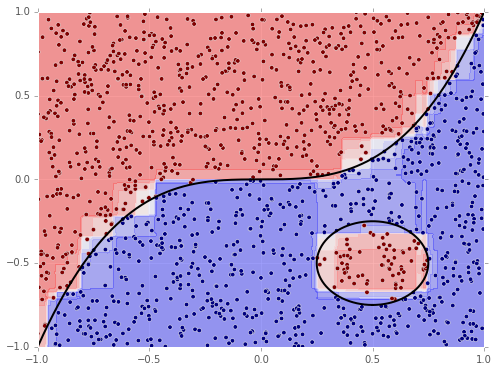

In [245]:
gx = np.linspace(-1, 1, 200)
gy = np.linspace(-1, 1, 200)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 11), 
             alpha=0.4, cmap=plt.cm.bwr_r)
plot_data()
plot_classification_boundary()

In [250]:
## Regression on the boston data set
N_ESTIMATORS = 2000

boston = datasets.load_boston()
X, y = boston['data'], boston['target']

(0, 20)

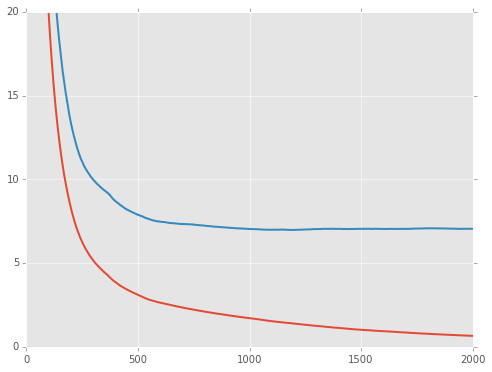

In [252]:
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.20, random_state=1)

model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
model.fit(X_train, y_train)

train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Score.")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Score")
plt.ylim([0, 20])